In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
from ssapp.data.AntennaDatasetLoaders import ReflectorCutDatasetComplex, ReflectorCutDataset
from torch.utils.data.dataloader import DataLoader
import torch

CUTS = 2
dataset_complex = ReflectorCutDatasetComplex(cuts = CUTS, mag_phase_transform=True)
dataset_simple = ReflectorCutDataset(cuts = CUTS)

complex_dataloader = DataLoader(dataset_complex)
dataloaderSimple = DataLoader(dataset_simple)







In [89]:
for parameters, mag, phase in iter(complex_dataloader):
    print('parameters',parameters)
    print(mag)
    print(phase)

parameters tensor([[0.0100, 0.4000, 0.0000]])
tensor([[[1.1917e-01, 2.6659e-16],
         [1.2138e-01, 2.0577e-16],
         [1.2358e-01, 2.6297e-16],
         ...,
         [1.2772e-01, 2.2672e-16],
         [1.2558e-01, 3.1403e-16],
         [1.2344e-01, 3.1774e-16]]])
tensor([[[-1.9121, -2.8017],
         [-1.8708, -2.8426],
         [-1.8303, -2.7655],
         ...,
         [-1.8192, -1.1066],
         [-1.8582, -1.1194],
         [-1.8980, -1.3924]]])
parameters tensor([[0.0100, 0.4889, 0.0000]])
tensor([[[1.0825e-01, 8.7676e-17],
         [1.1088e-01, 7.6471e-17],
         [1.1352e-01, 8.6348e-17],
         ...,
         [1.1430e-01, 2.9054e-16],
         [1.1170e-01, 2.6907e-16],
         [1.0911e-01, 3.1895e-16]]])
tensor([[[-0.7625, -2.7613],
         [-0.7191, -2.1574],
         [-0.6771, -1.7617],
         ...,
         [-0.6795, -2.6267],
         [-0.7214, -2.6651],
         [-0.7647, -2.6629]]])


In [90]:
from ssapp.data.AntennaDatasetLoaders import get_raw_dataset_path
import numpy as np

cut_dir, param_dir = get_raw_dataset_path('PatchAntennaDataset1')
print(cut_dir)

file_to_open = cut_dir / '0.cut'
param_file = param_dir / 'lookup.log'
cuts = 1 

antenna_parameters = np.genfromtxt(param_file, skip_header=1,skip_footer=343-cuts,dtype = np.float32)
antenna_parameters = antenna_parameters.reshape(cuts,4)[:,1:4]
print(antenna_parameters)


V_INI, V_INC, V_NUM, C, ICOMP, ICUT, NCOMP = np.genfromtxt(file_to_open, max_rows=1, skip_header=1)
V_NUM = int(V_NUM)

phi_cut = np.genfromtxt(file_to_open, skip_header=2, max_rows= V_NUM).reshape(1,V_NUM,1,4)
for i in range(1,3):
    phi_cut=np.append(phi_cut, np.genfromtxt(file_to_open, skip_header=2+i*(V_NUM+2), max_rows= V_NUM).reshape(1,V_NUM,1,4),axis=2)

print(phi_cut.shape)


c:\Users\Niels\Documents\GitHub\Supervised-Machine-Learning-for-Space-Antenna-Performance-Prediction\data\raw\PatchAntennaDataset1\cut_files
[[-2.   5.   2.9]]
(1, 361, 3, 4)


In [91]:
from ssapp.models.NeuralNetworkModels.Autoencoders import PatchAntenna1ConvAutoEncoder
from ssapp.data.AntennaDatasetLoaders import PatchAntennaDatasetComplex,PatchAntennaDataset
from torch.utils.data.dataloader import DataLoader
from sklearn.preprocessing import StandardScaler
from torch import optim
from torch import nn


data = PatchAntennaDataset(cuts=20)
patch_dataloader = DataLoader(data,batch_size=1)

model = PatchAntenna1ConvAutoEncoder(Latent_size = 20)

params,test_input = next(iter(patch_dataloader))
print(test_input.shape)

out = model.encode(test_input.float())

out = model.decode(out)

out = model(test_input.float())
print(out)
#  use gpu if available


# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu


# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# mean-squared error loss
criterion = nn.MSELoss()

torch.Size([1, 361, 3, 4])
tensor([[[[0.0358, 0.2153, 0.0272, 0.2058],
          [0.0562, 0.2176, 0.0214, 0.2084],
          [0.0551, 0.2153, 0.0252, 0.2051]],

         [[0.0603, 0.2177, 0.0256, 0.2075],
          [0.0603, 0.2183, 0.0234, 0.2106],
          [0.0578, 0.2182, 0.0224, 0.2071]],

         [[0.0585, 0.2169, 0.0251, 0.2057],
          [0.0585, 0.2185, 0.0267, 0.2076],
          [0.0572, 0.2183, 0.0235, 0.2096]],

         ...,

         [[0.2958, 0.3324, 0.3240, 0.2891],
          [0.2939, 0.3342, 0.3248, 0.2848],
          [0.2967, 0.3332, 0.3247, 0.2890]],

         [[0.2948, 0.3318, 0.3261, 0.2887],
          [0.2926, 0.3355, 0.3249, 0.2855],
          [0.2933, 0.3332, 0.3238, 0.2890]],

         [[0.2933, 0.3356, 0.3224, 0.2893],
          [0.2939, 0.3352, 0.3252, 0.2897],
          [0.2945, 0.3200, 0.3051, 0.3287]]]], grad_fn=<ViewBackward>)


In [92]:
EPOCHS = 50
data = PatchAntennaDataset(cuts = 10)
patch_dataloader = DataLoader(data,batch_size=1)
model = PatchAntenna1ConvAutoEncoder(Latent_size = 20)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# mean-squared error loss
criterion = nn.MSELoss()
for epoch in range(EPOCHS):
    
    for params, field in patch_dataloader:
    # reset the gradients back to zero
    # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        field = field.float()
        # compute reconstructions
        outputs = model(field)
            
        # compute training reconstruction loss
        train_loss = criterion(outputs, field)
            
        # compute accumulated gradients
        train_loss.backward()
            
        # perform parameter update based on current gradients
        optimizer.step()
            
        # add the mini-batch training loss to epoch loss
        loss = train_loss.item()
        
        # compute the epoch training loss
        loss = loss
    
    # display the epoch training loss
    if epoch % (EPOCHS/10) == 0:
        print("epoch : {}/{}, loss = {:.9e}".format(epoch + 1, EPOCHS, loss))

epoch : 1/50, loss = 1.805996597e-01
epoch : 6/50, loss = 3.487032279e-02
epoch : 11/50, loss = 2.837988921e-02
epoch : 16/50, loss = 2.856669016e-02
epoch : 21/50, loss = 2.842948027e-02
epoch : 26/50, loss = 2.843145840e-02
epoch : 31/50, loss = 2.788212337e-02
epoch : 36/50, loss = 2.730649151e-02
epoch : 41/50, loss = 2.596866712e-02
epoch : 46/50, loss = 2.486278862e-02


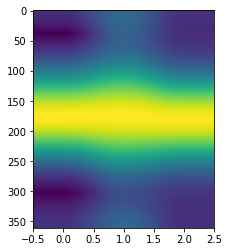

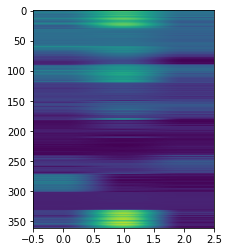

In [94]:
from matplotlib import pyplot as plt
params,test_input = next(iter(patch_dataloader))

output = model(test_input.float())

plt.figure()
plt.imshow(torch.abs(test_input[0,:,:,1:2]),aspect=1/100)
plt.figure()
plt.imshow(torch.abs(output[0,:,:,1:2].detach()),aspect=1/100)